In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

sub_size = 10
X_size = 200

X_star = np.linspace(0, 1, X_size)
X = X_star.reshape(-1,1)
# Evenly sample X_size points from sub_size points
sorted_indices = np.linspace(0, X_size-1, sub_size, dtype=int) 

X_sub = X[sorted_indices]
def RBF_kernel(X, Y, sigma2):
    X = np.array(X)
    Y = np.array(Y)
    mat1 = np.sum(X**2, 1).reshape(-1, 1)
    mat2 = np.sum(Y**2, 1)
    mat = mat1 + mat2 - 2 * np.dot(X, Y.T)
    mat = np.exp(-0.5 / sigma2 * mat)
    return mat

kTup = 1 # Hyperparameter： sigma squared
K = RBF_kernel(X_sub, X_sub, kTup) # Kernel Matrix of Fixed-Size Support Vectors

eigenvalue, featurevector = np.linalg.eig(K)     #Eigenvalue Decomposition of Kernel Matrix
A = eigenvalue             
B = featurevector

KK = RBF_kernel(X, X_sub, kTup)    # Kernel Matrix Generated from the Total Sample Set and Subsample Sets
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                # Primal form of the Sample Set Feature Function

X_F_1 = X_F[0,:]
X_F_1 = X_F_1.reshape(1, sub_size)

eigenvalue, featurevector = np.linalg.eig(K)    
A = eigenvalue             
B = featurevector
KK = RBF_kernel(X, X_sub, kTup)    
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                

X_F_N = X_F[-1,:]
X_F_N = X_F_N.reshape(1, sub_size)

X = X_star
X = X.reshape(-1,1)
X = X[1:-1]
KK = RBF_kernel(X, X_sub, kTup)    

X_diag = np.diag(X.flatten())  
X_sub_diag = np.diag(X_sub.flatten())  
KK_D = ( KK @ X_sub_diag - X_diag @ KK ) / (kTup)  # First-order derivative of the kernel function

eigenvalue, featurevector = np.linalg.eig(K)     
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                              

eigenvalue, featurevector = np.linalg.eig(K)   
A = eigenvalue             
B = featurevector
K_1 = KK_D @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_D = K_1 @ A_lam
X_F_D = F_D                                 # First-Order Derivative of the Sample Set Feature Function   

X = X_star
X = X.reshape(-1,1)
X = X[1:-1]
KK = RBF_kernel(X, X_sub, kTup)    

X_diag_squa = np.square(X_diag)
X_sub_diag_squa = np.square(X_sub_diag)
# Second-order derivative of the kernel function
KK_DD = KK/(-kTup) + ( KK @ X_sub_diag_squa -  2 * X_diag @ KK @ X_sub_diag  + X_diag_squa @ KK ) / (kTup) 

eigenvalue, featurevector = np.linalg.eig(K)   
A = eigenvalue             
B = featurevector
K_1 = KK_DD @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_DD = K_1 @ A_lam
X_F_DD = F_DD              # Second-Order Derivative of the Sample Set Feature Function              

r = 10000000   #Hyperparameter: gamma

from scipy.linalg import solve

nn = X_size - 2  # y
m_vars = sub_size # w

A = X_F_DD
B = X_F_D
C = X_F
D = X_F_1
E = X_F_N
I = np.ones((nn, 1))          # 1
p = 0
q = 0
e = np.e
max_iter = 500   # Maximum Number of Iterations
tol = 1e-10      # Convergence Tolerance
# Initial Guess 
w = np.zeros((m_vars, 1))
b = 0.0
m = 0.0
n = 0.0
y = np.zeros((nn, 1))
X = np.vstack([w, b, m, n, y])  
# Construct the matrix equation and solve it.    
for iter in range(max_iter):
    w = X[:m_vars].reshape(-1, 1)
    b = X[m_vars].item()
    m = X[m_vars+1].item()
    n = X[m_vars+2].item()
    y = X[m_vars+3:].reshape(-1, 1)
    
    Aw = A @ w
    Bw = B @ w
    Cw = C @ w
    e_iy = np.exp(-y)
    v = Aw + Bw**2 - 2 * e_iy
    u = Bw
    
    F = np.zeros((m_vars+nn+3, 1))
    
    Y1 = (w + r * A.T @ v 
          + 2 * r * B.T @ (u * v) 
          + r * (-C).T @ (y - Cw - b * I) 
          + m * D.T + n * E.T)
    F[:m_vars] = np.real(Y1)
    
    Y2 = r * (-I).T @ (y - Cw - b * I) + m + n
    F[m_vars] = np.real(Y2)
    
    Y3 = D @ w + b - p
    F[m_vars+1] = np.real(Y3)
    
    Y4 = E @ w + b - q
    F[m_vars+2] = np.real(Y4)
    
    Y5 = 2 * r * e_iy * v + r * (y - Cw - b * I)
    F[m_vars+3:] = np.real(Y5)
    
    if np.linalg.norm(F) < tol:
        print(f"Converged at iteration {iter}")
        break
    
    # J
    J = np.zeros((m_vars+nn+3, m_vars+nn+3))
    
    # Y1
    diag_Bw = np.diag(Bw.flatten())
    term2 = r * A.T @ (A + 2 * diag_Bw @ B)
    term3_part = np.diag(v.flatten()) @ B + np.diag(u.flatten()) @ (A + 2 * diag_Bw @ B)
    term3 = 2 * r * B.T @ term3_part
    term4 = r * C.T @ C
    dY1_dw = np.eye(m_vars) + term2 + term3 + term4
    J[:m_vars, :m_vars] = np.real(dY1_dw)
    
    dY1_db = r * C.T @ I
    J[:m_vars, m_vars] = np.real(dY1_db.flatten())
    
    J[:m_vars, m_vars+1] = np.real(D.T.flatten())
    J[:m_vars, m_vars+2] = np.real(E.T.flatten())
    
    diag_e_iy = np.diag(e_iy.flatten())
    term_y2 = -2 * r * A.T @ diag_e_iy
    term_y3 = -4 * r * B.T @ np.diag(u.flatten()) @ diag_e_iy
    term_y4 = -r * C.T
    dY1_dy = term_y2 + term_y3 + term_y4
    J[:m_vars, m_vars+3:] = np.real(dY1_dy)
    
    # Y2
    dY2_dw = (r * I.T @ C).reshape(1, -1)
    J[m_vars, :m_vars] = dY2_dw
    J[m_vars, m_vars] = r * (I.T)@(I)
    J[m_vars,m_vars+1] = 1
    J[m_vars, m_vars+2] = 1
    J[m_vars, m_vars+3:] = -r * I.T
    
    # Y3
    J[m_vars+1, :m_vars] = D
    J[m_vars+1, m_vars] = 1
    
    # Y4
    J[m_vars+2, :m_vars] = E
    J[m_vars+2, m_vars] = 1
    
    # Y5
    diag_e_iy_sq = np.diag((e_iy**2).flatten())
    term5_w = 2 * r * diag_e_iy @ (A + 2 * diag_Bw @ B) - r * C
    for i in range(nn):
        J[m_vars+3+i, :m_vars] = term5_w[i, :]
    
    J[m_vars+3:, m_vars] = -r * I.flatten()
    
    term5_y = (-2 * r * diag_e_iy @ np.diag(v.flatten()) 
               + 4 * r * diag_e_iy_sq + r * np.eye(nn))
    J[m_vars+3:, m_vars+3:] = term5_y

    delta_X = solve(J, -F)
    X += delta_X
    if iter == max_iter - 1:
        print("Max iterations reached.")
    print(f"Iteration {iter}: Residual norm = {np.linalg.norm(F):.4e}")    

W = X[:m_vars]
b = X[m_vars]

#Calculate the prediction results.
X = X_star
X = X.reshape(-1,1)
KK = RBF_kernel(X, X_sub, kTup)     
eigenvalue, featurevector = np.linalg.eig(K)    
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)
F = K_1 @ A_lam
X_F = F                                 

y_p =  np.real(np.dot(X_F,W) + b.item())

C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.01833e-22): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=1.16291e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.43072e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.43096e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.42511e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned m

Iteration 0: Residual norm = 1.7754e+10
Iteration 1: Residual norm = 1.1862e+10
Iteration 2: Residual norm = 5.8587e+07
Iteration 3: Residual norm = 3.0515e+07
Iteration 4: Residual norm = 2.9778e+07
Iteration 5: Residual norm = 2.8885e+07
Iteration 6: Residual norm = 2.7997e+07
Iteration 7: Residual norm = 2.7116e+07
Iteration 8: Residual norm = 2.6245e+07
Iteration 9: Residual norm = 2.5385e+07
Iteration 10: Residual norm = 2.4538e+07
Iteration 11: Residual norm = 2.3706e+07
Iteration 12: Residual norm = 2.2889e+07
Iteration 13: Residual norm = 2.2089e+07
Iteration 14: Residual norm = 2.1306e+07
Iteration 15: Residual norm = 2.0542e+07
Iteration 16: Residual norm = 1.9796e+07
Iteration 17: Residual norm = 1.9070e+07
Iteration 18: Residual norm = 1.8363e+07
Iteration 19: Residual norm = 1.7676e+07
Iteration 20: Residual norm = 1.7009e+07
Iteration 21: Residual norm = 1.6362e+07
Iteration 22: Residual norm = 1.5734e+07
Iteration 23: Residual norm = 1.5126e+07
Iteration 24: Residual nor

C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29573e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29548e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29525e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29502e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29481e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned m

Iteration 76: Residual norm = 1.5579e+06
Iteration 77: Residual norm = 1.4903e+06
Iteration 78: Residual norm = 1.4257e+06
Iteration 79: Residual norm = 1.3639e+06
Iteration 80: Residual norm = 1.3047e+06
Iteration 81: Residual norm = 1.2481e+06
Iteration 82: Residual norm = 1.1939e+06
Iteration 83: Residual norm = 1.1420e+06
Iteration 84: Residual norm = 1.0924e+06
Iteration 85: Residual norm = 1.0450e+06
Iteration 86: Residual norm = 9.9953e+05
Iteration 87: Residual norm = 9.5607e+05
Iteration 88: Residual norm = 9.1449e+05
Iteration 89: Residual norm = 8.7470e+05
Iteration 90: Residual norm = 8.3664e+05
Iteration 91: Residual norm = 8.0023e+05
Iteration 92: Residual norm = 7.6540e+05
Iteration 93: Residual norm = 7.3207e+05
Iteration 94: Residual norm = 7.0019e+05
Iteration 95: Residual norm = 6.6969e+05
Iteration 96: Residual norm = 6.4052e+05
Iteration 97: Residual norm = 6.1261e+05
Iteration 98: Residual norm = 5.8591e+05
Iteration 99: Residual norm = 5.6037e+05
Iteration 100: R

C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29018e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29017e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29016e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29015e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29014e-21): result may not be accurate.
  delta_X = solve(J, -F)
C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned m

Iteration 169: Residual norm = 2.4546e+04
Iteration 170: Residual norm = 2.3472e+04
Iteration 171: Residual norm = 2.2445e+04
Iteration 172: Residual norm = 2.1463e+04
Iteration 173: Residual norm = 2.0523e+04
Iteration 174: Residual norm = 1.9625e+04
Iteration 175: Residual norm = 1.8767e+04
Iteration 176: Residual norm = 1.7946e+04
Iteration 177: Residual norm = 1.7160e+04
Iteration 178: Residual norm = 1.6409e+04
Iteration 179: Residual norm = 1.5691e+04
Iteration 180: Residual norm = 1.5005e+04
Iteration 181: Residual norm = 1.4348e+04
Iteration 182: Residual norm = 1.3720e+04
Iteration 183: Residual norm = 1.3120e+04
Iteration 184: Residual norm = 1.2546e+04
Iteration 185: Residual norm = 1.1997e+04
Iteration 186: Residual norm = 1.1472e+04
Iteration 187: Residual norm = 1.0970e+04
Iteration 188: Residual norm = 1.0490e+04
Iteration 189: Residual norm = 1.0031e+04
Iteration 190: Residual norm = 9.5918e+03
Iteration 191: Residual norm = 9.1721e+03
Iteration 192: Residual norm = 8.7

C:\Users\90765\AppData\Local\Temp\ipykernel_67016\615251125.py:249: LinAlgWarning: Ill-conditioned matrix (rcond=9.29009e-21): result may not be accurate.
  delta_X = solve(J, -F)


Iteration 370: Residual norm = 3.0428e+00
Iteration 371: Residual norm = 2.9096e+00
Iteration 372: Residual norm = 2.7823e+00
Iteration 373: Residual norm = 2.6605e+00
Iteration 374: Residual norm = 2.5441e+00
Iteration 375: Residual norm = 2.4327e+00
Iteration 376: Residual norm = 2.3262e+00
Iteration 377: Residual norm = 2.2244e+00
Iteration 378: Residual norm = 2.1270e+00
Iteration 379: Residual norm = 2.0339e+00
Iteration 380: Residual norm = 1.9449e+00
Iteration 381: Residual norm = 1.8598e+00
Iteration 382: Residual norm = 1.7784e+00
Iteration 383: Residual norm = 1.7006e+00
Iteration 384: Residual norm = 1.6261e+00
Iteration 385: Residual norm = 1.5549e+00
Iteration 386: Residual norm = 1.4869e+00
Iteration 387: Residual norm = 1.4218e+00
Iteration 388: Residual norm = 1.3596e+00
Iteration 389: Residual norm = 1.3001e+00
Iteration 390: Residual norm = 1.2432e+00
Iteration 391: Residual norm = 1.1888e+00
Iteration 392: Residual norm = 1.1367e+00
Iteration 393: Residual norm = 1.0

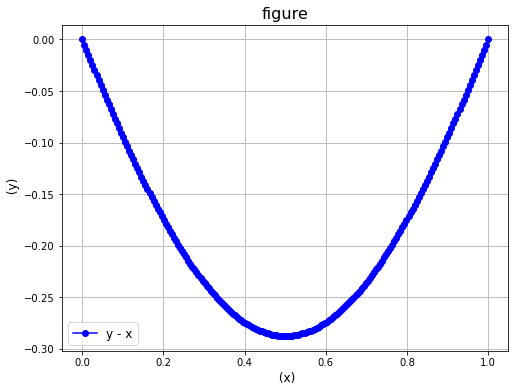

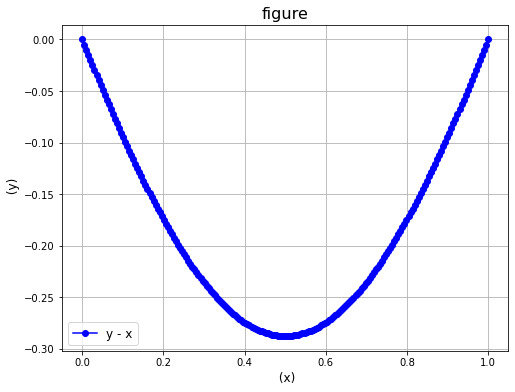

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = X 
a = y_p
y = y_p             
plt.figure(figsize=(8, 6))  
plt.plot(x, y, label="y - x", color="blue", linestyle="-", marker="o")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


x = X 
y_t = np.log((x - 1/2)**2 + 3/4)
y_t = np.array(y_t)
b = y_t
y = y_t         
plt.figure(figsize=(8, 6))  
plt.plot(x, y, label="y - x", color="blue", linestyle="-", marker="o")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_p_fsvm = a
y_true = b
R2_fsvm = r2_score(y_p_fsvm, y_true.reshape(-1, 1))
mae_fsvm = mean_absolute_error(y_p_fsvm, y_true.reshape(-1, 1))
rmse_fsvm = mean_squared_error(y_p_fsvm, y_true.reshape(-1, 1), squared = False)
inf_norm_fsvm = np.linalg.norm(y_p_fsvm - y_true.reshape(-1, 1), ord = np.inf)

print(f"R2_fsvm: {R2_fsvm}, mae_fsvm: {mae_fsvm}, rmse_fsvm: {rmse_fsvm}, inf_norm_fsvm: {inf_norm_fsvm}") 


import pandas as pd

data_to_save = pd.DataFrame({
    'y_pred_fsvm': y_p_fsvm.flatten()
})
data_to_save.to_csv('fsvm_14.csv', index=False)
print(" fsvm_14.csv")

R2_fsvm: 0.9999999996810655, mae_fsvm: 1.1723036335586304e-06, rmse_fsvm: 1.5749854148002793e-06, inf_norm_fsvm: 3.845357864129539e-06
数据已保存至 fsvm_14.csv
